# 📘 Project :  Introduction to Transformers: Text Classification 

##  Description  
This notebook compares predictions from two different deep learning models — an **LSTM** and a **fine-tuned Transformer (DistilBERT)** — on the IMDB sentiment classification dataset. It focuses on identifying disagreement cases between the models and analyzing them using **Explainable AI (XAI)** techniques.

---

##  Key Components

- **Model Loading**  
  Imports and loads pre-trained LSTM and DistilBERT models from saved checkpoints.

- **Prediction & Comparison**  
  Runs both models on the same input data and compares their predictions.

- **Conflict Score Calculation**  
  Computes a conflict score based on the absolute difference in confidence levels when the models disagree:

  $$
  \text{Conflict Score} = |\text{Conf}_{\text{LSTM}} - \text{Conf}_{\text{BERT}}|
  $$

- **XAI Visualizations**  
  - Uses **LIME** to interpret LSTM decisions  
  - Uses **SHAP** and/or **attention heatmaps** to interpret BERT predictions

- **Conflict Summary Dashboard**  
  - Displays metrics such as number and percentage of disagreements  
  - Visualizes conflict score distribution using graphs (bar charts, pie charts, etc.)

---

##  Libraries Used  
- TensorFlow  
- Hugging Face Transformers  
- LIME  
- SHAP  
- Matplotlib, Seaborn  
- Pandas, Plotly

---

##  Dataset  
Loaded from:  
```python
tensorflow_datasets.load('imdb_reviews')


---
##  Step 1: BiLSTM Model – Predictions & Confidence Analysis

In this section, we load predictions made by the BiLSTM model and analyze its behavior.  
We look at:
- How confident the model was in its predictions
- How confidence relates to correctness
- Distribution of predicted probabilities

This gives us a baseline understanding of how the LSTM-based model is performing before comparing it with the Transformer model.

---


In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [84]:
# Load BiLSTM Predictions
bilstm_df = pd.read_csv("C:/Users/VISMAYA/Documents/Dl_project/person_a_lstm/bilstm_predictions.csv")

bilstm_df.head()


,Actual,Predicted,Predicted_Prob
0,0,0,0.099347
1,1,1,0.996351
2,1,1,0.729536
3,0,0,0.032132
4,1,1,0.998706


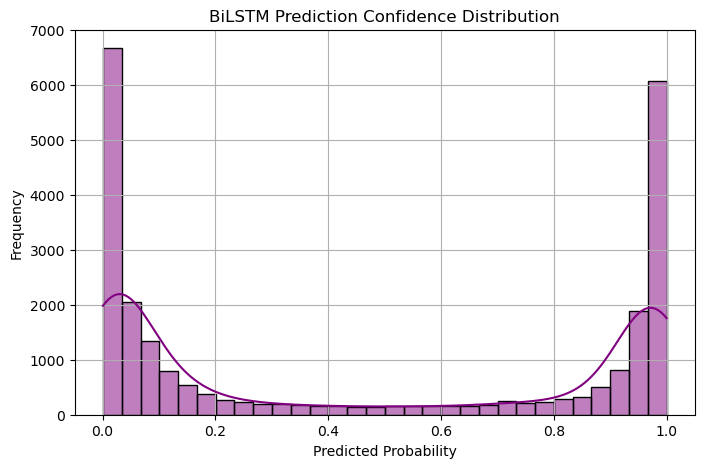

In [85]:
# Plot Confidence Score Distribution
#This shows how confident the BiLSTM model was when making predictions.
plt.figure(figsize=(8, 5))
sns.histplot(bilstm_df["Predicted_Prob"], bins=30, kde=True, color="purple")
plt.title("BiLSTM Prediction Confidence Distribution")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


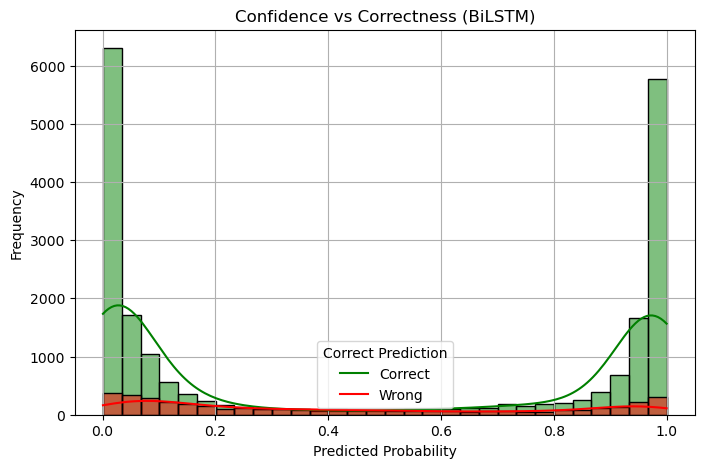

In [86]:
# Add a new column: whether the prediction was correct
#It stores True if the model prediction matches the actual label, else False.
bilstm_df["Correct"] = bilstm_df["Actual"] == bilstm_df["Predicted"]

# Plot Confidence vs Correctness
#Green bars show correct predictions, red bars show incorrect ones.
plt.figure(figsize=(8, 5))
sns.histplot(data=bilstm_df, x="Predicted_Prob", hue="Correct", bins=30, kde=True, palette={True: "green", False: "red"})
plt.title("Confidence vs Correctness (BiLSTM)")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.legend(title="Correct Prediction", labels=["Correct", "Wrong"])
plt.grid(True)
plt.show()


In [9]:
!pip install lime


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283840 sha256=0d6697ecaa41e97f79d75f94f2cb664495b9c6e96289c9c718785a72f922d7c9
  Stored in directory: c:\users\vismaya\appdata\local\pip\cache\wheels\e7\5d\0e\4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


---
## 🧪 Step 2: Explaining BiLSTM Predictions with LIME

In this section, we use **LIME (Local Interpretable Model-Agnostic Explanations)** to understand how the BiLSTM model makes decisions for individual reviews.  
We decode the integer-encoded reviews back into text, define a prediction function that LIME can use, and then visualize what parts of a review most influenced the model's decision.

---


In [89]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load trained BiLSTM model
model = load_model("C:/Users/VISMAYA/Documents/Dl_project/person_a_lstm/bilstm_model.keras")

#  Load IMDB Test Data (for decoding & LIME)
vocab_size = 10000
maxlen = 200
(_, _), (x_test, y_test) = imdb.load_data(num_words=vocab_size)
x_test = pad_sequences(x_test, maxlen=maxlen)

# Reverse word index for decoding reviews
word_index = imdb.get_word_index()
reverse_word_index = {value: key for key, value in word_index.items()}

# Function to decode a review from integer tokens to readable text
def decode_review(sequence):
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in sequence if i >= 3])


C:\Users\VISMAYA\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 11 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [90]:
# Preprocessing Function for LIME
# Converts raw text into integer sequences (just like how training was done)
def lime_preprocess(texts, word_index, vocab_size=10000, maxlen=200):
    sequences = []
    for text in texts:
        tokens = text.lower().split()
        seq = []
        for word in tokens:
            index = word_index.get(word)
            if index is not None and index < vocab_size:
                seq.append(index + 3)  # Offset for reserved tokens
        sequences.append(seq)
    return pad_sequences(sequences, maxlen=maxlen)


In [91]:
#  Define Custom Prediction Function for LIME
# This takes raw text input and returns prediction probabilities
def predict_proba(texts):
    sequences = lime_preprocess(texts, word_index)
    probs = model.predict(sequences)
    return np.hstack((1 - probs, probs))  # Return shape: (n_samples, 2)


In [92]:
#  Select a Sample Review from Test Set to Explain
sample_idx = 10
sample_text = decode_review(x_test[sample_idx])
print("🔍 Sample review:\n", sample_text)


🔍 Sample review:
 of two men murders in exchange for getting rid of the two people messing up their lives throw from the train is an original and very inventive comedy take on the idea it's a credit to danny that he both wrote and starred in this minor comedy gem br br anne is the mother who the film's title and it's understandable why she gets under the skin of danny with her sharp tongue and relentlessly putting him down for any minor billy crystal is the writer who's wife has stolen his book idea and is now being as a great new author even appearing on the oprah show to in he should be enjoying thus gets the idea of murders to rid themselves of these factors br br of course everything and anything can happen when writer carl lets his imagination with ideas for how the plot develops and it's amusing all the way through providing plenty of laughs and chuckles along the way as well as a good deal of suspense br br for of black comedy this one is guaranteed to please


In [95]:
from lime.lime_text import LimeTextExplainer

#  Run LIME Explanation
explainer = LimeTextExplainer(class_names=["Negative", "Positive"])
exp = explainer.explain_instance(sample_text, predict_proba, num_features=10)

#  Show Explanation
exp.show_in_notebook(text=True)


157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 106ms/step


---
## Step 3: DistilBERT Predictions and SHAP-based Interpretability

This section focuses on analyzing the DistilBERT model's prediction confidence and understanding *why* it makes certain decisions.  
We begin by visualizing confidence scores, then load a fine-tuned Transformer model and interpret misclassified predictions using **SHAP** (SHapley Additive exPlanations).

Key Steps:
- Load BERT prediction results and visualize confidence distributions.
- Use the Hugging Face Transformers library to load the pre-trained model.
- Match raw text reviews to predictions.
- Apply SHAP to explain why a misclassified review was predicted wrongly.

---

In [56]:
# Import basic libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the prediction results generated by the DistilBERT model
bert_df = pd.read_csv("C:\\Users\\VISMAYA\\Documents\\Dl_project\\person_b_bert\\DistilBERT_Predictions.csv")


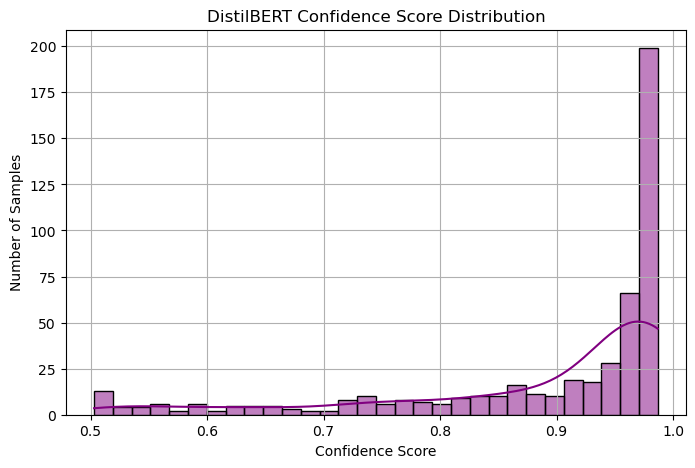

In [57]:
# Visualize the overall distribution of prediction confidence scores
plt.figure(figsize=(8, 5))
sns.histplot(data=bert_df, x="Predicted_prob", bins=30, kde=True, color="purple")
plt.title("DistilBERT Confidence Score Distribution")
plt.xlabel("Confidence Score")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()


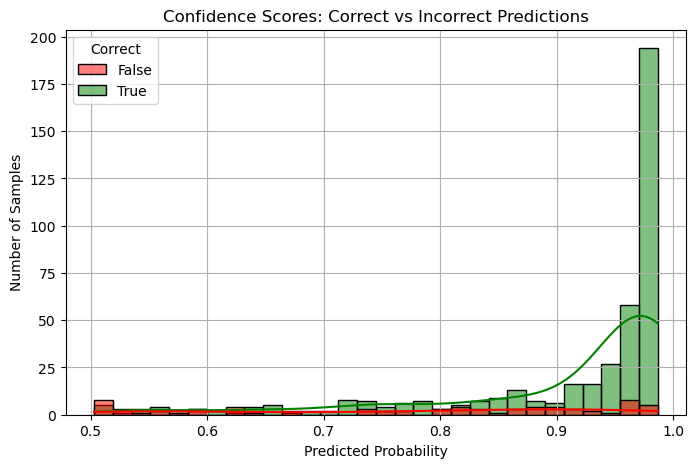

In [58]:
# Add a new column to mark whether the prediction was correct or not
bert_df["Correct"] = bert_df["Actual"] == bert_df["Predicted"]

# Plot how confidence scores vary for correct vs incorrect predictions
plt.figure(figsize=(8, 5))
sns.histplot(data=bert_df, x="Predicted_prob", hue="Correct", bins=30, kde=True,
             palette={True: "green", False: "red"})
plt.title("Confidence Scores: Correct vs Incorrect Predictions")
plt.xlabel("Predicted Probability")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()


In [6]:
pip install shap transformers tensorflow


   ---------------------------------------- 0.0/545.3 kB ? eta -:--:--
   ---------------------------------------- 545.3/545.3 kB 9.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [59]:
# Load a pre-trained DistilBERT model and tokenizer using Hugging Face Transformers
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
import tensorflow as tf

model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)


All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [66]:
# Define a function to return class probabilities for a given list of texts
import numpy as np

def predict_proba(texts):
    # SHAP might send a tuple like (masked_text, )
    if isinstance(texts, tuple):
        texts = texts[0]

    # Convert any single text into a list
    if isinstance(texts, str):
        texts = [texts]
    elif isinstance(texts, np.ndarray):
        texts = texts.tolist()

    # Now tokenize
    tokens = tokenizer(
        texts,
        max_length=200,
        truncation=True,
        padding=True,
        return_tensors="tf"
    )

    # Get predictions
    logits = model(tokens).logits
    probs = tf.nn.softmax(logits, axis=1).numpy()
    return probs



In [67]:
# Load the IMDB dataset to retrieve the original review texts
from datasets import load_dataset
dataset = load_dataset("imdb")

# Attach the first N test texts to the BERT DataFrame so we can interpret predictions
test_texts = dataset['test']['text']
bert_df["Text"] = test_texts[:len(bert_df)]


In [68]:
# Prepare to explain a misclassified example using SHAP
import shap

# Select one misclassified review from the dataset
sample_text = bert_df[bert_df["Correct"] == False]["Text"].iloc[0]


In [69]:
# Use SHAP's Text Masker
masker = shap.maskers.Text(tokenizer)

# Create SHAP explainer
explainer = shap.Explainer(predict_proba, masker)

# Explain the model's prediction for this one misclassified review
shap_values = explainer([str(sample_text)])  # ensure it's a regular string
shap.plots.text(shap_values[0])

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [03:27, 207.60s/it]                                                                  


---
### Step 4: BERT vs LSTM Conflict Analysis

In this section, we compare the predictions made by the DistilBERT and BiLSTM models.  
The goal is to identify samples where both models disagree and analyze the extent of their disagreement.

We begin by merging both models’ predictions and renaming columns for clarity.  
A **conflict score** is calculated as the absolute difference between the predicted probabilities from both models.

Finally, we extract the top conflicting samples and visualize the distribution of conflict scores to better understand where the models diverge the most.

---

In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load predictions from BERT and LSTM models
bert_df = pd.read_csv("C:\\Users\\VISMAYA\\Documents\\Dl_project\\person_b_bert\\DistilBERT_Predictions.csv")
lstm_df = pd.read_csv("C:\\Users\\VISMAYA\\Documents\\Dl_project\\person_a_lstm\\bilstm_predictions.csv")

In [71]:
# Show available columns 
print("BERT Columns:", bert_df.columns.tolist())
print("LSTM Columns:", lstm_df.columns.tolist())

BERT Columns: ['Actual', 'Predicted', 'Predicted_prob']
LSTM Columns: ['Actual', 'Predicted', 'Predicted_Prob']


In [72]:
# Rename columns for clarity and to avoid name collisions
bert_df.rename(columns={
    "Predicted": "BERT_Pred",
    "Predicted_prob": "BERT_Prob"
}, inplace=True)

lstm_df.rename(columns={
    "Predicted": "LSTM_Pred",
    "Predicted_Prob": "LSTM_Prob"
}, inplace=True)

In [73]:
# Combine both predictions into a single DataFrame
df = pd.DataFrame({
    "Actual": bert_df["Actual"],
    "BERT_Pred": bert_df["BERT_Pred"],
    "BERT_Prob": bert_df["BERT_Prob"],
    "LSTM_Pred": lstm_df["LSTM_Pred"],
    "LSTM_Prob": lstm_df["LSTM_Prob"]
})

In [74]:
# Calculate how much the two models disagree on confidence
df["Conflict_Score"] = abs(df["BERT_Prob"] - df["LSTM_Prob"])

# Keep only the rows where predictions from BERT and LSTM differ
conflicts_df = df[df["BERT_Pred"] != df["LSTM_Pred"]]

# Sort by highest disagreement
conflict_df_sorted = conflicts_df.sort_values(by="Conflict_Score", ascending=False)

# Show top 10 conflicting predictions
top_conflicts = conflict_df_sorted.head(10)
print(top_conflicts)

       Actual BERT_Pred  BERT_Prob  LSTM_Pred  LSTM_Prob  Conflict_Score
490  Negative  Negative   0.984801          0   0.001098        0.983703
216  Negative  Negative   0.985554          0   0.003866        0.981687
61   Negative  Negative   0.983247          0   0.003183        0.980063
141  Negative  Negative   0.985480          0   0.006413        0.979066
281  Negative  Negative   0.984529          0   0.006523        0.978006
340  Negative  Negative   0.982465          0   0.004518        0.977948
312  Positive  Positive   0.982827          0   0.005488        0.977339
471  Positive  Positive   0.977554          0   0.000663        0.976891
404  Positive  Positive   0.977699          0   0.001042        0.976657
165  Positive  Positive   0.980296          0   0.003970        0.976326


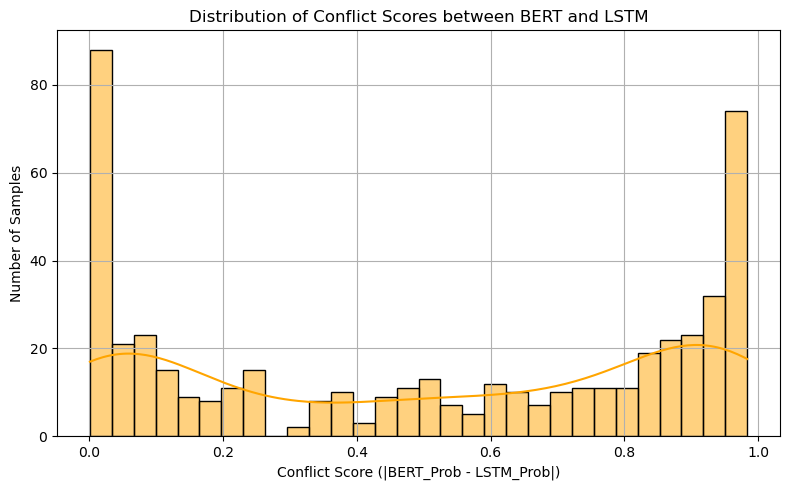

In [75]:
# Plot distribution of conflict scores
plt.figure(figsize=(8, 5))
sns.histplot(conflicts_df["Conflict_Score"], bins=30, color='orange', kde=True)
plt.title("Distribution of Conflict Scores between BERT and LSTM")
plt.xlabel("Conflict Score (|BERT_Prob - LSTM_Prob|)")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.tight_layout()
plt.show()

In [76]:
import pandas as pd
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizer
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [77]:
# Load and check prediction files
print("Files loaded successfully!")
print("BERT columns:", bert_df.columns)
print("LSTM columns:", lstm_df.columns)


Files loaded successfully!
BERT columns: Index(['Actual', 'BERT_Pred', 'BERT_Prob'], dtype='object')
LSTM columns: Index(['Actual', 'LSTM_Pred', 'LSTM_Prob'], dtype='object')


In [78]:
# Load pre-trained DistilBERT model and tokenizer
bert_model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

# Load fine-tuned BiLSTM model
lstm_model = load_model("C:\\Users\\VISMAYA\\Documents\\Dl_project\\person_a_lstm\\bilstm_model.keras")

print("Both models are ready for prediction!")

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


Both models are ready for prediction!


C:\Users\VISMAYA\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 11 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [79]:
# Set parameters (must match what was used during training)
VOCAB_SIZE = 10000
MAX_LEN = 200

# Load IMDB word index
word_index = imdb.get_word_index()

# Adjust indices for special tokens
word_index = {k: (v + 3) for k, v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
word_index["<UNUSED>"] = 3

# Create reverse index for decoding if needed
reverse_word_index = {value: key for key, value in word_index.items()}

# Function to encode text like we did during LSTM training
def encode_lstm_review(text):
    words = text.lower().split()
    encoded = [1]  # Add <START> token
    for word in words:
        if word in word_index and word_index[word] < VOCAB_SIZE:
            encoded.append(word_index[word])
        else:
            encoded.append(2)  # Use <UNK> for unknown words
    return pad_sequences([encoded], maxlen=MAX_LEN, padding='post')

In [80]:
# Predict sentiment using DistilBERT
def predict_bert(text):
    inputs = tokenizer(text, truncation=True, padding=True, max_length=512, return_tensors="tf")
    outputs = bert_model(inputs)
    probs = tf.nn.softmax(outputs.logits, axis=1).numpy()[0]
    pred = int(probs.argmax())
    label = "Positive" if pred == 1 else "Negative"
    confidence = probs[pred]
    return label, confidence

# Predict sentiment using LSTM
def predict_lstm(review):
    encoded_review = encode_lstm_review(review)
    prediction = lstm_model.predict(encoded_review)
    confidence = float(prediction[0][0])
    label = "Positive" if confidence > 0.5 else "Negative"
    return label, confidence

In [98]:
# Compare both models on a given text
def compare_models_on_text(text):
    print("\nInput Review:", text)

    bert_label, bert_conf = predict_bert(text)
    print(f"BERT Prediction: {bert_label} ({bert_conf:.2f} confidence)")

    lstm_label, lstm_conf = predict_lstm(text)
    print(f"LSTM Prediction: {lstm_label} ({lstm_conf:.2f} confidence)")

    if bert_label == lstm_label:
        print(" Both models agree on sentiment.")
    else:
        print(" Models disagree on sentiment!")

    if abs(bert_conf - lstm_conf) > 0.15:
        stronger = "BERT" if bert_conf > lstm_conf else "LSTM"
        print(f" {stronger} was more confident in its prediction.")

In [ ]:
# Let user input reviews for comparison
while True:
    user_input = input("\nEnter a review to analyze (or type 'exit' to stop): ")
    if user_input.lower() == 'exit':
        print("Done! You can now use this loop to demo your project live.")
        break
    compare_models_on_text(user_input)






Enter a review to analyze (or type 'exit' to stop):  love!



Input Review: love!
BERT Prediction: Positive (1.00 confidence)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
LSTM Prediction: Positive (0.81 confidence)
 Both models agree on sentiment.
 BERT was more confident in its prediction.



Enter a review to analyze (or type 'exit' to stop):  awfully good



Input Review: awfully good
BERT Prediction: Positive (1.00 confidence)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
LSTM Prediction: Positive (0.82 confidence)
 Both models agree on sentiment.
 BERT was more confident in its prediction.
